In [1]:
import os
import sys
import random

import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

from datetime import datetime

from keras_segmentation.models.unet import vgg_unet

from Config import tf, np, get_logger
from Datagen.train2 import DataGen_2
from Dataset import Dataset
from Callbacks import OnEpochEnd

from contextlib import redirect_stdout

print("TensorFlow version: ", tf.__version__)

logger = get_logger()

TensorFlow version:  2.4.1


In [2]:
tf.config.list_physical_devices('GPU')
#if tf.test.gpu_device_name(): 
#    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
#else:
#   print("Please install GPU version of TF")
#tf.test.gpu_device_name()

#from tensorflow.python.client import device_lib
#def get_available_devices():
#    local_device_protos = device_lib.list_local_devices()
#    return [x.name for x in local_device_protos]
#print(get_available_devices()) 


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
data = Dataset()
train_ids, valid_ids = data.load_main_data()


----------- files for validation 1898, files for training 7594 -----------


In [12]:
data = Dataset()
train_ids, valid_ids = data.load_filtered_rotated_data()

----------- files for validation 1600, files for training 11572 -----------


In [2]:
data = Dataset()
train_ids, valid_ids = data.load_filtered_data()

----------- files for validation 1449, files for training 5797 -----------


In [2]:
#ROAD SIDE DATA
data = Dataset()
train_ids, valid_ids = data.load_complicated_data()

----------- files for validation 300, files for training 1284 -----------


In [3]:
#TURNS AND SHADED MAUNAL MASKS
data = Dataset()
train_ids, valid_ids = data.load_filtered_data_224_657_rgb()


# 133/525
# new 97/360

count = 0
for idx in valid_ids:
    if 'MANUAL2' in idx:
        count = count + 1
        #print(count)
        #print(str(count) + ") " + idx)
print(count)


----------- files for validation 1449, files for training 5796 -----------
97


In [4]:
#gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
#x, y = gen.__getitem__(0)
gen_all = DataGen_2(train_ids, data.path, batch_size=data.batch_size, image_size=data.image_size)
x, y = gen_all.__getitem__(0)
print(x.shape, y.shape)

(8, 224, 224, 3) (8, 224, 224, 1)


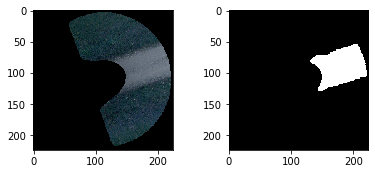

In [5]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (data.image_size, data.image_size)), cmap="gray")

In [13]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    #us = tf.keras.layers.UpSampling2D((2, 2))(x)
    #cv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    deconv2 = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=(2, 2), padding=padding)(x)
    concat = tf.keras.layers.Concatenate()([deconv2, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [14]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = tf.keras.layers.Input((data.image_size, data.image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = tf.keras.models.Model(inputs, outputs)
    return model



In [15]:
model = UNet()

#Also takes into account true negative numbers
def iou_loss(y_true, y_pred):
    total_iou = 0
    total_iou = total_iou - K.sum(y_true * y_pred) / K.sum(1-(1-y_true) * (1-y_pred))
    return total_iou 

function_iou_loss = iou_loss


#Same as upper method. This method excludes division with zero was used as a loss function. Did not improve
def rene_iou(y_true, y_pred):
    t = K.reshape(y_true, (-1, 1))
    p = K.reshape(y_pred, (-1, 1))
    tn = 1.0 - t
    pn = 1.0 - p
    return -1.0 * tf.math.divide_no_nan(K.sum(t*p), K.sum(1.0 - tn*pn))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss="binary_crossentropy", 
    metrics=["acc", function_iou_loss]
) 

#pole päris õige binary_crossentropy saab lisada metricu ja kasutada kulufunktsiooni. Näitab mulle kas liigun. Precision recall. 
# optimizer võiks olla adam asemel adadelta. Learning rate peaks olema 1. acc asmel eraldi klass
model.summary()

#with open('modelsummary.txt', 'w') as f:
#    with redirect_stdout(f):
#        model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 224, 224, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 224, 224, 16) 2320        conv2d_43[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 112, 112, 16) 0           conv2d_44[0][0]                  
____________________________________________________________________________________________

In [17]:
train_gen = DataGen_2(train_ids, data.path, image_size=data.image_size, batch_size=data.batch_size)
valid_gen = DataGen_2(valid_ids, data.path, image_size=data.image_size, batch_size=data.batch_size)
epochs = 100


train_steps = len(train_ids)//data.batch_size
valid_steps = len(valid_ids)//data.batch_size

filename_date = datetime.now().strftime("%Y%m%d-%H%M%S")

csv_logger = CSVLogger('/home/raul/mahb/project/logs/training/'+filename_date+'.log')

print("Training begin time: " + str(datetime.now().strftime("%Y.%m.%d %H:%M:%S")))

#learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#tf.keras.callbacks.TensorBoard(
#    log_dir='logs', update_freq='epoch',
#   profile_batch=0,                      # <-- default value is 2
#)

model.fit(
    train_gen, 
    validation_data=valid_gen, 
    steps_per_epoch=None, 
    validation_steps=valid_steps, 
    epochs=epochs, 
    callbacks=[
        csv_logger, 
        OnEpochEnd([train_gen.on_epoch_end]),
        tensorboard_callback
    ], 
    shuffle=True
)

print("Training end time: " + str(datetime.now().strftime("%Y.%m.%d %H:%M:%S")))

Training begin time: 2021.05.06 11:08:23
Epoch 1/100
725/725 [==============================] - 40s 50ms/step - loss: 0.2566 - acc: 0.9347 - iou_loss: -0.4259 - val_loss: 0.0583 - val_acc: 0.9795 - val_iou_loss: -0.7660
Epoch 2/100
725/725 [==============================] - 23s 32ms/step - loss: 0.0521 - acc: 0.9815 - iou_loss: -0.7772 - val_loss: 0.0639 - val_acc: 0.9775 - val_iou_loss: -0.7884
Epoch 3/100
725/725 [==============================] - 24s 33ms/step - loss: 0.0452 - acc: 0.9817 - iou_loss: -0.8040 - val_loss: 0.0339 - val_acc: 0.9854 - val_iou_loss: -0.8530
Epoch 4/100
725/725 [==============================] - 24s 33ms/step - loss: 0.0338 - acc: 0.9861 - iou_loss: -0.8478 - val_loss: 0.0272 - val_acc: 0.9899 - val_iou_loss: -0.8807
Epoch 5/100
725/725 [==============================] - 24s 33ms/step - loss: 0.0295 - acc: 0.9884 - iou_loss: -0.8687 - val_loss: 0.0289 - val_acc: 0.9886 - val_iou_loss: -0.8768
Epoch 6/100
725/725 [==============================] - 24s 33ms/

In [21]:
## Save the Weights
filename = filename_date + "_epochs-" + str(epochs) + "_imagesize-" + str(data.image_size) + "_batchsize-" + str(data.batch_size)

model.save_weights("model/" + filename + ".h5")

file_model = "model/" + filename + ".json"
model_json = model.to_json()
with open(file_model, "w") as json_file:
    json_file.write(model_json)

filepath = "model/"+filename+".tf"
tf.keras.models.save_model(
    model, filepath, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None
)

desc_model = "generator/" + filename + ".txt"
with open(desc_model, "w") as desc_file:
    desc_file.write(data.path)

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

#treshold tulemused ja tulemustel ta teeb tresholdi ära osa pilt kümme pilti. andmete struktuur jääb samaks. 0.32 paneb väärtuseks kui see jääb alla. pixli tasemel käib otsus. 
result = result > 0.5

INFO:tensorflow:Assets written to: model/20210506-110823_epochs-100_imagesize-224_batchsize-8.tf/assets


In [10]:
valid_gen = DataGen(valid_ids, all_train_path, image_size=image_size, batch_size=batch_size, custom_path = all_train_path_rdmasks)

x, y = valid_gen.__getitem__(5, True)

current_batch = valid_gen.current_batch_images

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1):

    ax = fig.add_subplot(2, 2, 1)
    ax.title.set_text('Original')
    ax.imshow(x[i][:, :, [2, 1, 0]])

    result = model.predict(x)

    #image_path = os.path.join(all_train_path, current_batch[i][:current_batch[i].index("-")], current_batch[i]) + ".jpg"

    print(current_batch[i])

    result = result > 0.5

    #fig = plt.figure()
    #fig.subplots_adjust(hspace=0.4, wspace=0.4)

    fig = plt.figure(figsize=(8,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    ax = fig.add_subplot(1, 2, 1)
    ax.title.set_text('Mask')
    ax.imshow(np.reshape(y[i]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 2, 2)
    ax.title.set_text('Prediction')
    ax.imshow(np.reshape(result[i]*255, (image_size, image_size)), cmap="gray")


NameError: name 'all_train_path' is not defined

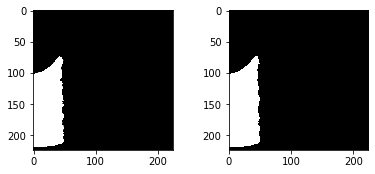

In [11]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[4]*255, (data.image_size, data.image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[4]*255, (data.image_size, data.image_size)), cmap="gray")